In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


pd.set_option('display.width', 1000) #Extend the width of plot
# Doc for dataset: 
# https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2
# https://www.kaggle.com/code/sharanharsoor/aircraft-predictive-maintenance/notebook

# Dataset exploration

In [2]:
print('\n Train dataset \n')
df_train = pd.read_csv('PM_train.txt',  sep=" ", header=None)
# Let's drop the NAN columns 26 and 27 using the dropna() method.
df_train.dropna(axis=1, inplace=True)
# Let's define the columns
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

df_train.columns = cols_names
print(df_train.head())

'''
Aircraft cycles data. We have 20631 cycles, with 3 settings parameters and 21 sensors parameters. 
Each time series can be assumed as being generated from a different engine of the same type. Each engine is assumed to start with different degrees of initial wear and manufacturing variation, and this information is unknown to the user. In this simulated data, the engine is assumed to be operating normally at the start of each time series. It starts to degrade at some point during the series of the operating cycles. The degradation progresses and grows in magnitude. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine. Taking the sample training data shown in the following table as an example, the engine with id=1 fails at cycle 192, and engine with id=2 fails at cycle 287.
'''


 Train dataset 

   id  cycle  setting1  setting2  setting3      s1      s2       s3       s4     s5  ...     s12      s13      s14     s15   s16  s17   s18    s19    s20      s21
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044

[5 

'\nAircraft cycles data. We have 20631 cycles, with 3 settings parameters and 21 sensors parameters. \nEach time series can be assumed as being generated from a different engine of the same type. Each engine is assumed to start with different degrees of initial wear and manufacturing variation, and this information is unknown to the user. In this simulated data, the engine is assumed to be operating normally at the start of each time series. It starts to degrade at some point during the series of the operating cycles. The degradation progresses and grows in magnitude. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine. Taking the sample training data shown in the following table as an example, the engine with id=1 fails at cycle 192, and engine with id=2 fails at cycle 287.\n'

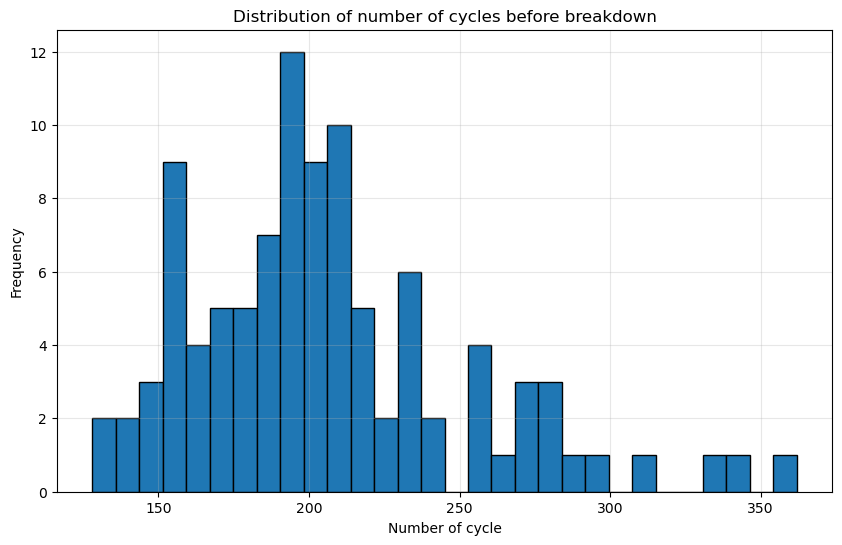

There is an average of 206.31 cycles before breakdown


In [3]:
#Let's plot the distribution of number of cycles per ids. We'll have an idea approximately of the number of cycle the engine can go through before breakdown

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_train.groupby('id').count()['cycle'], bins=30, edgecolor='black')
plt.title('Distribution of number of cycles before breakdown')
plt.xlabel('Number of cycle')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

print("There is an average of {} cycles before breakdown".format(df_train.groupby('id').count()['cycle'].mean()))


In [4]:
# Filter the dataset for ids below 2
df_filtered = df_train[df_train['id'] <= 2]

# Get the list of metrics (excluding 'id' and 'cycle')
metrics = [col for col in df_train.columns if col not in ['id', 'cycle']]

# Create the figure
fig = go.Figure()

# Add traces for each id and metric
for id_val in df_filtered['id'].unique():
    df_id = df_filtered[df_filtered['id'] == id_val]
    for metric in metrics:
        fig.add_trace(
            go.Scatter(
                x=df_id['cycle'],
                y=df_id[metric],
                name=f'ID {id_val} - {metric}',
                visible=False
            )
        )

# Create and add dropdown menu
buttons = []
for i, metric in enumerate(metrics):
    button = dict(
        method='update',
        label=metric,
        args=[{'visible': [False] * len(fig.data)},
              {'title': f'Evolution of {metric} per ID and Cycle'}]
    )
    # Set visibility for the correct traces
    for j in range(len(df_filtered['id'].unique())):
        button['args'][0]['visible'][i + j * len(metrics)] = True
    buttons.append(button)

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.1,
        yanchor="top"
    )]
)

# Set the initial visibility (show the first metric)
for i in range(len(df_filtered['id'].unique())):
    fig.data[i * len(metrics)].visible = True

# Update layout
fig.update_layout(
    title=f'Evolution of {metrics[0]} per ID and Cycle',
    xaxis_title='Cycle',
    yaxis_title='Value',
    legend_title='ID - Metric'
)

# Show the plot
fig.show()

> We can observe for example that the sensor 2 has a tendency to increase before breakdown.

> We can observe similar pattern for each sensor which can give us clues on the evolution before breakdown.

## Let's have a look at the testing dataset

In [5]:
print('\n Test dataset \n')
df_test = pd.read_csv('PM_test.txt',  sep=" ", header=None)
# Let's drop the NAN columns 26 and 27 using the dropna() method.
df_test.dropna(axis=1, inplace=True)
# Let's define the columns
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

df_test.columns = cols_names
print(df_test.head())

'''
The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs (in other words, the last time period does NOT represent the failure point). Taking the sample testing data shown in the following table as an example, the engine with id=1 runs from cycle 1 through cycle 31. It is not shown how many more cycles this engine can last before it fails.
'''



 Test dataset 

   id  cycle  setting1  setting2  setting3      s1      s2       s3       s4     s5  ...     s12      s13      s14     s15   s16  s17   s18    s19    s20      s21
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0  38.86  23.3735
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0  39.02  23.3916
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0  39.08  23.4166
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0  39.00  23.3737
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0  38.99  23.4130

[5 r

'\nThe testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs (in other words, the last time period does NOT represent the failure point). Taking the sample testing data shown in the following table as an example, the engine with id=1 runs from cycle 1 through cycle 31. It is not shown how many more cycles this engine can last before it fails.\n'

> We can plot the evolution of s2 sensor per cycle for the first id

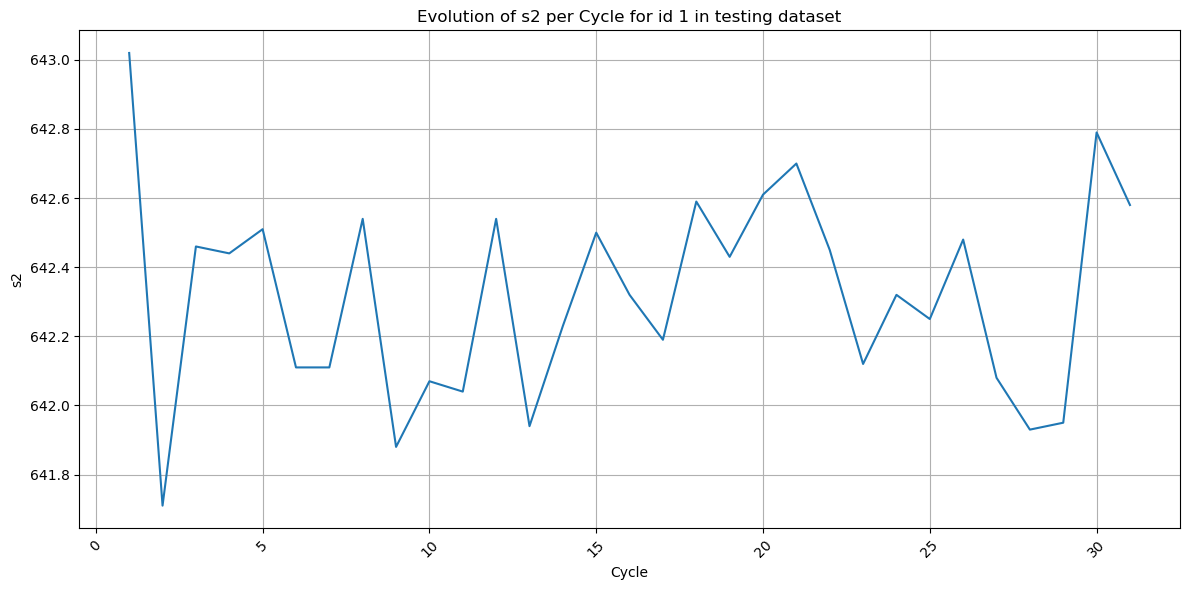

In [6]:
# Create a new figure
plt.figure(figsize=(12, 6))
# Plot voltage for each machine ID

plt.plot(df_test[df_test['id']==1]['cycle'], df_test[df_test['id']==1]['s2'])

# Customize the plot
plt.title('Evolution of s2 per Cycle for id 1 in testing dataset')
plt.xlabel('Cycle')
plt.ylabel('s2')
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

> We can see that for the testing dataset, we don't have all cycles until breakdown. The truth dataset will tell us for what cycle did the 1st id broke down

In [7]:
print('\n Truth dataset \n')
df_truth = pd.read_csv('PM_truth.txt',  sep=" ", header=None)
df_truth.dropna(axis=1, inplace=True)
df_truth.columns = ['remaining_cycle']

# We'll setup the index as the "id" column
df_truth.reset_index(inplace=True)
df_truth = df_truth.rename(columns={'index': 'id'})
df_truth['id'] = df_truth['id']+1

print(df_truth.head())

'''
The ground truth data provides the number of remaining working cycles for the engines in the testing data. Taking the sample ground truth data shown in the following table as an example, the engine with id=1 in the testing data can run another 112 cycles before it fails.
'''


 Truth dataset 

   id  remaining_cycle
0   1              112
1   2               98
2   3               69
3   4               82
4   5               91


'\nThe ground truth data provides the number of remaining working cycles for the engines in the testing data. Taking the sample ground truth data shown in the following table as an example, the engine with id=1 in the testing data can run another 112 cycles before it fails.\n'

# Framing the problem
> We can approach the issue either from a Regression point of view or Classification point of view. <br>
From a Regression point of view, we would be trying to predict the exact cycle of breakdown, and we would evaluate with metrics such as MSE etc.<br>
From a Classification point of view, we would rather be trying to predict if the engine would breakdown in the next cycles. Then we would evaluate with metrics such as F1 score, True positive, Confusion matrix etc.<br><br>
From a Business point of view, I would think that the Classification point of view makes more sense, as it would allow us to setup a maintenance whenever we believe the breakdown will appear in the next cycles. We can even later develop more complex models, giving probability of breakdown with different windos.<br><br>
As a first approach, let's say we want to predict if the engine will breakdown in the next 20 cycles.<br>

# Dummy approach
> Let's have a first dummy approach to visualize how we can tackle the problem from a Classification point of view, and how we can evaluate the model.
We've seen before that sensor 2 seemed to increase before the engine breakdown.
Let's create a model predicting the engine breakdown, whenever s2 values are higher than average

## Focusing on s2 evolution on the training set
> Let's compute multiple things for each ID:
* The average of s2 values on the first cycles
* The value of s2 and its difference, 20 cycles before breakdown

In [8]:
df_train_dummy = df_train.copy(deep=True)[['id', 'cycle', 's2']]

# This is the average of s2 values on the first 30 cycles per id
avg_s2_first_30 = df_train_dummy[df_train_dummy['cycle'] <= 30].groupby('id')['s2'].mean().reset_index()
avg_s2_first_30.columns = ['id', 'avg_s2_first_30']
df_train_dummy = df_train_dummy.merge(avg_s2_first_30, on='id', how='left')

# This is the failing cycle for each id
max_cycle = df_train_dummy.groupby('id')['cycle'].max().reset_index()
max_cycle.columns = ['id', 'max_cycle']
df_train_dummy = df_train_dummy.merge(max_cycle, on='id', how='left')

# This is the difference between s2 value, 20 cycle before failure, and our average. We compute it on a 10d window
s2_window_20 = df_train_dummy[(df_train_dummy['cycle']>=df_train_dummy['max_cycle']-30) & (df_train_dummy['cycle']<=df_train_dummy['max_cycle']-20)].groupby('id')['s2'].mean().reset_index()
s2_window_20.columns = ['id', 's2_window_20']
df_train_dummy = df_train_dummy.merge(s2_window_20, on='id', how='left')
df_train_dummy['s2_window_20_vs_avg'] = (df_train_dummy['s2_window_20'] - df_train_dummy['avg_s2_first_30'])*100/df_train_dummy['s2_window_20']

print(df_train_dummy)

        id  cycle      s2  avg_s2_first_30  max_cycle  s2_window_20  s2_window_20_vs_avg
0        1      1  641.82       642.328333        192    643.061818             0.114061
1        1      2  642.15       642.328333        192    643.061818             0.114061
2        1      3  642.35       642.328333        192    643.061818             0.114061
3        1      4  642.35       642.328333        192    643.061818             0.114061
4        1      5  642.37       642.328333        192    643.061818             0.114061
...    ...    ...     ...              ...        ...           ...                  ...
20626  100    196  643.49       642.425667        200    643.127273             0.109093
20627  100    197  643.54       642.425667        200    643.127273             0.109093
20628  100    198  643.42       642.425667        200    643.127273             0.109093
20629  100    199  643.23       642.425667        200    643.127273             0.109093
20630  100    200  64

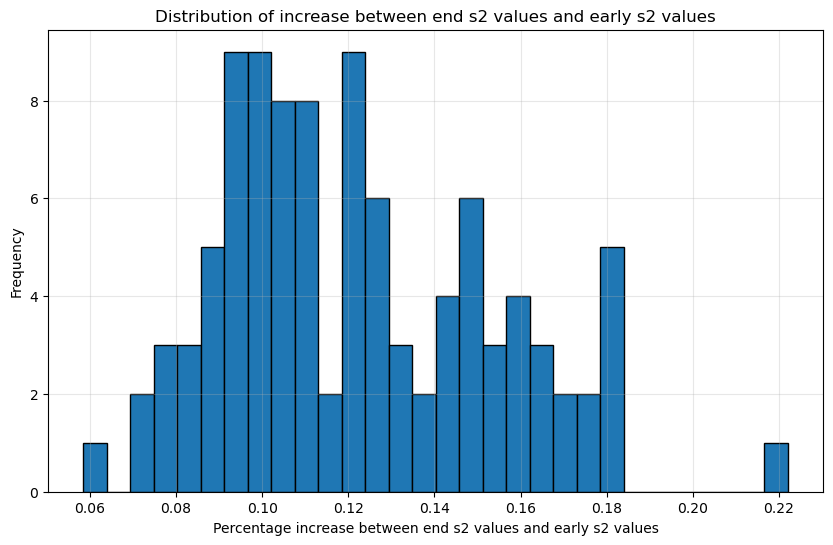

In [9]:
# Let's plot the distribution of the end s2 values 20 cycles before breakdown, vs average early s2 values

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_train_dummy.groupby('id').mean()['s2_window_20_vs_avg'], bins=30, edgecolor='black')
plt.title('Distribution of increase between end s2 values and early s2 values')
plt.xlabel('Percentage increase between end s2 values and early s2 values')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

> Ok so we have our dummy model: let's say that whenever our s2 values computed on a 10 days window, are 0.08% above our early s2 values (first 30 cycles), we'll predict the engine will fail in the next 20 cycles.

> Let's apply the logic to our testing dataset

In [10]:
df_test_dummy = df_test.copy(deep=True)[['id', 'cycle', 's2']]
# Let's apply the same transformations

# This is the average of s2 values on the first 30 cycles per id
avg_s2_first_30 = df_test_dummy[df_test_dummy['cycle'] <= 30].groupby('id')['s2'].mean().reset_index()
avg_s2_first_30.columns = ['id', 'avg_s2_first_30']
df_test_dummy = df_test_dummy.merge(avg_s2_first_30, on='id', how='left')

# This is the failing cycle for each id
max_cycle = df_test_dummy.groupby('id')['cycle'].max().reset_index()
max_cycle.columns = ['id', 'max_cycle']
df_test_dummy = df_test_dummy.merge(max_cycle, on='id', how='left')

# This is the difference between s2 value, 20 cycle before failure, and our average. We compute it on a 10d window
s2_window_20 = df_test_dummy[(df_test_dummy['cycle']>=df_test_dummy['max_cycle']-30) & (df_test_dummy['cycle']<=df_test_dummy['max_cycle']-20)].groupby('id')['s2'].mean().reset_index()
s2_window_20.columns = ['id', 's2_window_20']
df_test_dummy = df_test_dummy.merge(s2_window_20, on='id', how='left')
df_test_dummy['s2_window_20_vs_avg'] = (df_test_dummy['s2_window_20'] - df_test_dummy['avg_s2_first_30'])*100/df_test_dummy['s2_window_20']

# Now we make our prediction
df_test_dummy['will_breakdown_in_next_20_cycles'] = df_test_dummy['s2_window_20_vs_avg'] >= 0.08

print(df_test_dummy)

        id  cycle      s2  avg_s2_first_30  max_cycle  s2_window_20  s2_window_20_vs_avg  will_breakdown_in_next_20_cycles
0        1      1  643.02       642.310333         31    642.262727            -0.007412                             False
1        1      2  641.71       642.310333         31    642.262727            -0.007412                             False
2        1      3  642.46       642.310333         31    642.262727            -0.007412                             False
3        1      4  642.44       642.310333         31    642.262727            -0.007412                             False
4        1      5  642.51       642.310333         31    642.262727            -0.007412                             False
...    ...    ...     ...              ...        ...           ...                  ...                               ...
13091  100    194  643.24       642.196000        198    642.628182             0.067252                             False
13092  100    19

In [11]:
pred_dummy = df_test_dummy.groupby('id').max()['will_breakdown_in_next_20_cycles'].reset_index()
pred_dummy.columns = ['id', 'will_breakdown_in_next_20_cycles_pred']
pred_dummy.groupby('will_breakdown_in_next_20_cycles_pred').count()

,id
will_breakdown_in_next_20_cycles_pred,
False,87
True,13


> We are predicting 13 breakdowns coming in the next 20 cycles from out testing dataset. <br>
Let's evaluate vs the truth.

In [12]:
df_truth_dummy_evaluate = df_truth.copy(deep=True)
df_truth_dummy_evaluate['will_breakdown_in_next_20_cycles_truth'] = df_truth_dummy_evaluate['remaining_cycle'] <= 20
df_truth_dummy_evaluate = pd.merge(df_truth_dummy_evaluate, pred_dummy, on='id')
print(df_truth_dummy_evaluate)

     id  remaining_cycle  will_breakdown_in_next_20_cycles_truth  will_breakdown_in_next_20_cycles_pred
0     1              112                                   False                                  False
1     2               98                                   False                                  False
2     3               69                                   False                                  False
3     4               82                                   False                                  False
4     5               91                                   False                                  False
..  ...              ...                                     ...                                    ...
95   96              137                                   False                                  False
96   97               82                                   False                                  False
97   98               59                                   False

Accuracy: 0.8900
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.95      0.94        84
        True       0.69      0.56      0.62        16

    accuracy                           0.89       100
   macro avg       0.81      0.76      0.78       100
weighted avg       0.88      0.89      0.89       100



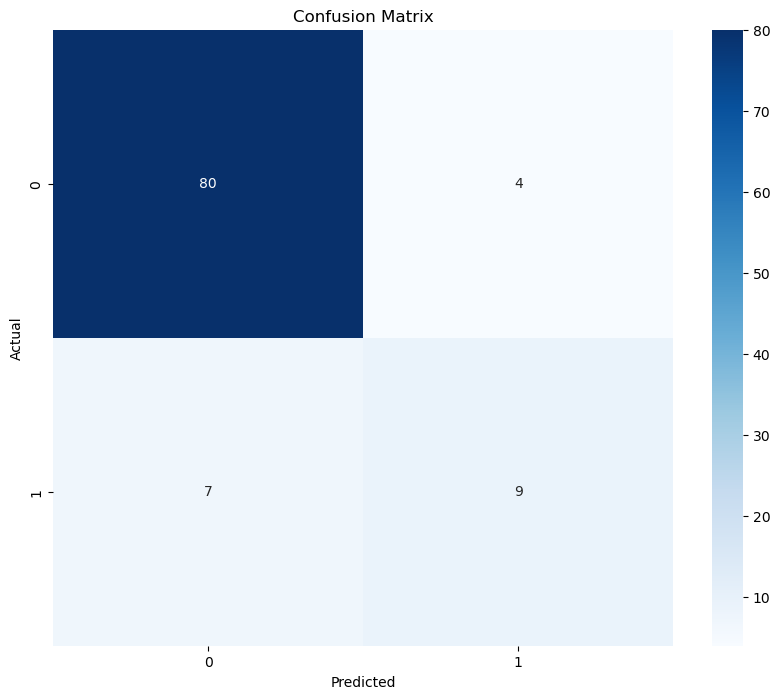

In [13]:
'''
Function to evaluate our prediction, compute accuracy and plot a confusion matrix
'''
def evaluate_pred(predicted, truth):
    # Calculate accuracy
    accuracy = (truth == predicted).mean()
    print(f"Accuracy: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(truth, predicted)
    print("Classification Report:")
    print(report)
    # Generate confusion matrix
    conf_matrix = confusion_matrix(truth, predicted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_pred(df_truth_dummy_evaluate['will_breakdown_in_next_20_cycles_pred'], df_truth_dummy_evaluate['will_breakdown_in_next_20_cycles_truth'])

> We can see that our dummy model is not so bad! <br>
With an accuracy of 89%, and a F1 score of 94%. <br>
We could adapt our level of False positive or False negative by adapting our threshold, or we could use other sensors than s2. <br>
But let's focus on more complex methods.

# Random Forest Classifier

In [14]:
df_train_rf = df_train.copy(deep=True)

# Identify the failure cycle for each engine
failure_cycles = df_train_rf.groupby('id')['cycle'].max()

# Create the target variable
# We define a cycle as failure when it is less than 20 cycles away from the last cycle
# So that we can train our algorithm to predict if we are less than 20 cycles away from breakdown
df_train_rf['failure'] = df_train_rf.apply(lambda x: 1 if x['cycle'] >= failure_cycles[x['id']] - 20 else 0, axis=1)

# Select features
# We select every setting and sensor
features = ['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]

# Split the data
# For our case we already have a testing dataset so we'll take all of the training
X = df_train_rf[features]
y = df_train_rf['failure']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y)

RandomForestClassifier(random_state=42)

In [15]:
# Now that we have a model, let's apply it to our testing dataset
# We'll apply the same transformations
# We should only take the last cycle of each id, and predict if there will be breakdown in the next 20 cycles

df_test_rf = df_test.copy(deep=True)
last_cycles = df_test_rf.groupby('id')['cycle'].max()
#We just take the last cycle
df_test_rf['last_cycle'] = df_test_rf.apply(lambda x: 1 if x['cycle'] == last_cycles[x['id']] else 0, axis=1)
df_test_rf = df_test_rf[df_test_rf['last_cycle']==1]

X_test = df_test_rf[features]
X_test_scaled = scaler.fit_transform(X_test)

y_pred = model.predict(X_test_scaled)


In [16]:
df_truth_rf_evaluate = df_truth.copy(deep=True)
df_truth_rf_evaluate['will_breakdown_in_next_20_cycles_truth'] = df_truth_rf_evaluate['remaining_cycle'] <= 20
df_truth_rf_evaluate['will_breakdown_in_next_20_cycles_pred'] = y_pred
print(df_truth_rf_evaluate)

     id  remaining_cycle  will_breakdown_in_next_20_cycles_truth  will_breakdown_in_next_20_cycles_pred
0     1              112                                   False                                      0
1     2               98                                   False                                      0
2     3               69                                   False                                      0
3     4               82                                   False                                      0
4     5               91                                   False                                      0
..  ...              ...                                     ...                                    ...
95   96              137                                   False                                      0
96   97               82                                   False                                      0
97   98               59                                   False

Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.99      0.95        84
        True       0.90      0.56      0.69        16

    accuracy                           0.92       100
   macro avg       0.91      0.78      0.82       100
weighted avg       0.92      0.92      0.91       100



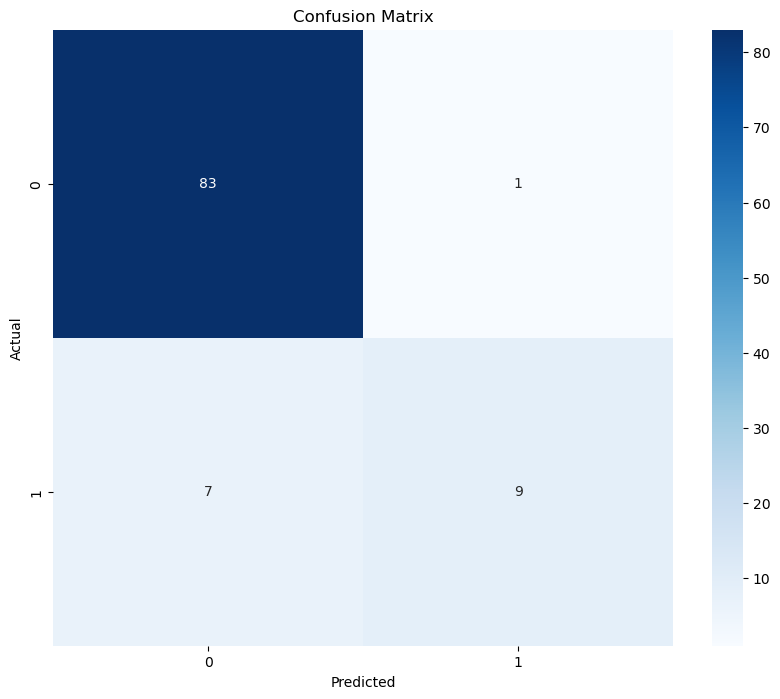

In [17]:
evaluate_pred(df_truth_rf_evaluate['will_breakdown_in_next_20_cycles_pred'], df_truth_rf_evaluate['will_breakdown_in_next_20_cycles_truth'])

> We can see that compared to our Dummy approach we have reduced our False Positive and increased our True Negative. The accuracy and F1 score are better. The main problem of the model is still on the False Negative. 
Let's try with a XGBoost model

# XGBoost model

In [18]:
df_train_xgb = df_train.copy(deep=True)

# Identify the failure cycle for each engine
failure_cycles = df_train_rf.groupby('id')['cycle'].max()

# Create the target variable
# We define a cycle as failure when it is less than 20 cycles away from the last cycle
# So that we can train our algorithm to predict if we are less than 20 cycles away from breakdown
df_train_xgb['failure'] = df_train_xgb.apply(lambda x: 1 if x['cycle'] >= failure_cycles[x['id']] - 20 else 0, axis=1)

# Select features
# We select every setting and sensor
features = ['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]

# Split the data
# For our case we already have a testing dataset so we'll take all of the training
X = df_train_xgb[features]
y = df_train_xgb['failure']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

# Train the model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_scaled, y)

/opt/miniconda3/envs/data_science/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning:

[11:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [19]:
# Now that we have a model, let's apply it to our testing dataset
# We'll apply the same transformations
# We should only take the last cycle of each id, and predict if there will be breakdown in the next 20 cycles

df_test_xgb = df_test.copy(deep=True)
last_cycles = df_test_xgb.groupby('id')['cycle'].max()
#We just take the last cycle
df_test_xgb['last_cycle'] = df_test_xgb.apply(lambda x: 1 if x['cycle'] == last_cycles[x['id']] else 0, axis=1)
df_test_xgb = df_test_xgb[df_test_xgb['last_cycle']==1]

X_test = df_test_xgb[features]
X_test_scaled = scaler.fit_transform(X_test)

y_pred = model.predict(X_test_scaled)


In [20]:
df_truth_xgb_evaluate = df_truth.copy(deep=True)
df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_truth'] = df_truth_xgb_evaluate['remaining_cycle'] <= 20
df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_pred'] = y_pred
print(df_truth_xgb_evaluate)

     id  remaining_cycle  will_breakdown_in_next_20_cycles_truth  will_breakdown_in_next_20_cycles_pred
0     1              112                                   False                                      0
1     2               98                                   False                                      0
2     3               69                                   False                                      0
3     4               82                                   False                                      0
4     5               91                                   False                                      0
..  ...              ...                                     ...                                    ...
95   96              137                                   False                                      0
96   97               82                                   False                                      0
97   98               59                                   False

Accuracy: 0.9300
Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.99      0.96        84
        True       0.91      0.62      0.74        16

    accuracy                           0.93       100
   macro avg       0.92      0.81      0.85       100
weighted avg       0.93      0.93      0.92       100



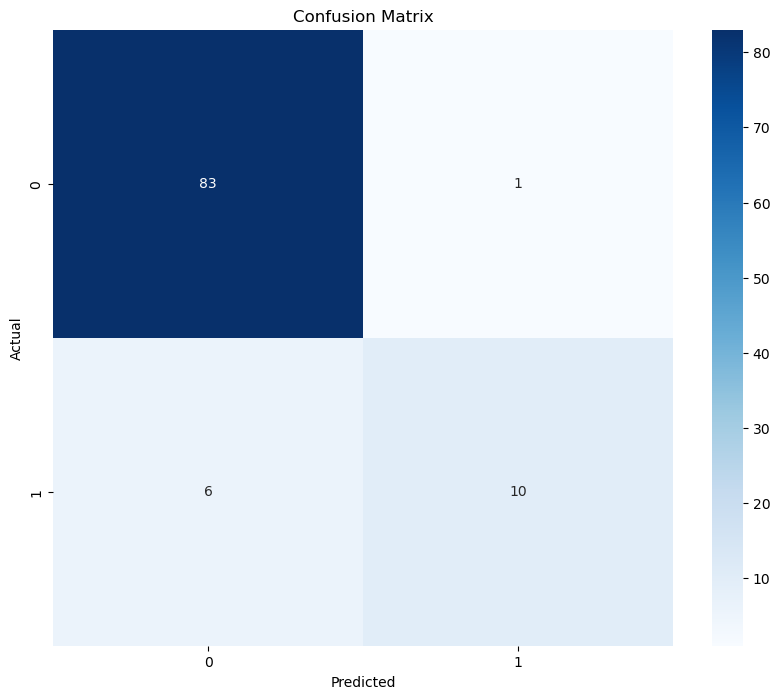

In [21]:
evaluate_pred(df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_pred'], df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_truth'])

> Our XGBoost is a bit better than our Random Forest model! <br>
Let's visualize a bit more the cases when our prediction is wrong 

In [35]:
xgb_merged = pd.merge(df_truth_xgb_evaluate[df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_pred']!=df_truth_xgb_evaluate['will_breakdown_in_next_20_cycles_truth']], df_test_xgb, how='inner', on='id')

print(xgb_merged)

   id  remaining_cycle  will_breakdown_in_next_20_cycles_truth  will_breakdown_in_next_20_cycles_pred  cycle  setting1  setting2  setting3      s1      s2  ...      s13      s14     s15   s16  s17   s18    s19    s20      s21  last_cycle
0  20               16                                    True                                      0    184   -0.0006   -0.0004     100.0  518.67  643.75  ...  2388.21  8138.86  8.4690  0.03  395  2388  100.0  38.35  23.0242           1
1  24               20                                    True                                      0    186   -0.0004    0.0002     100.0  518.67  643.28  ...  2388.07  8211.21  8.4785  0.03  393  2388  100.0  38.72  23.2093           1
2  31                8                                    True                                      0    196   -0.0005    0.0001     100.0  518.67  643.31  ...  2388.22  8157.84  8.5015  0.03  395  2388  100.0  38.53  23.1105           1
3  36               19                          